# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Preliminaries

In [1]:
import math
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ipywidgets import interact, fixed
from moviepy.editor import VideoFileClip
from collections import deque
#from IPython.display import HTML
%matplotlib inline

## Camera calibration

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
files = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
images =[]
for fname in files:
    #read in image
    img = mpimg.imread(fname)
    # Find the chessboard corners
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        images.append(img)
        # Draw the corners
        #img = cv2.drwChessboardCorners(img, (9,6), corners, ret)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)

### Distortion correction

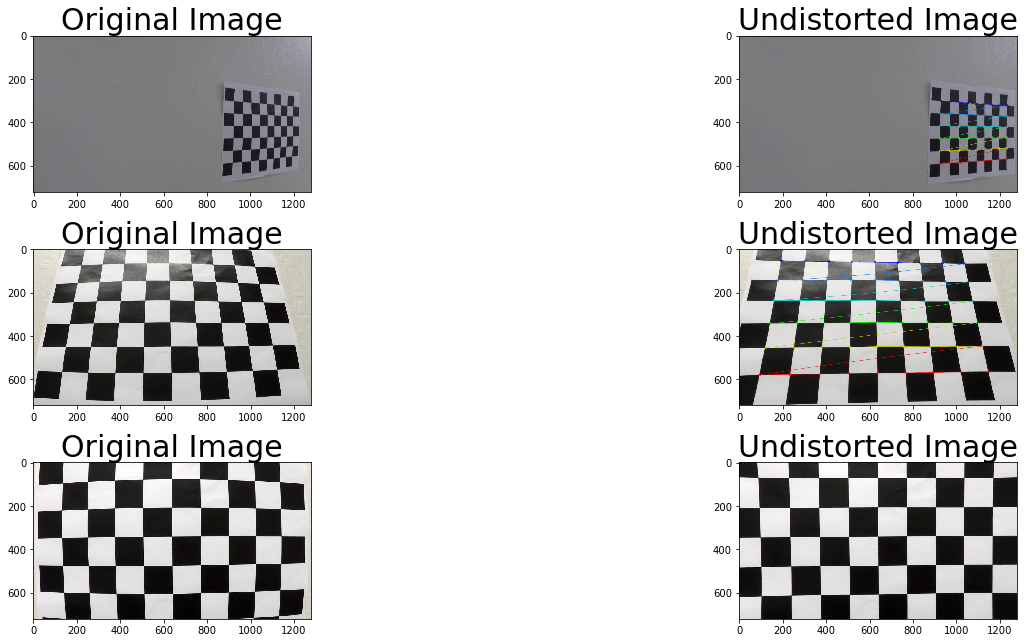

In [3]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #undist = np.copy(img)  # Delete this line
    return undist

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(24,9))
test_images = [images[0], images[15], mpimg.imread('camera_cal/test_image.jpg')]
#test_images.append(image[9])
#test_images.append(image[15])

for i, ax in enumerate(axes):
    ax1, ax2 = ax
    img = test_images[i]
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

    undistorted = cal_undistort(img, objpoints, imgpoints)

    ax2.imshow(undistorted)
    ax2.set_title('Undistorted Image', fontsize=30)

fig.tight_layout()
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Color/gradient threshold

### Color/gradient threshold functions

In [4]:
def grad_threshold(img, orient='x', sobel_kernel=3, grad_thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    thresh_min = grad_thresh[0]
    thresh_max = grad_thresh[1]    
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return grad_binary

def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    grad_mag = np.sqrt(sobelx**2 + sobely**2)
    scaled_mag_sobel = np.uint8(255*grad_mag/np.max(grad_mag))
    thresh_min = mag_thresh[0]
    thresh_max = mag_thresh[1]
    mag_binary = np.zeros_like(scaled_mag_sobel)
    mag_binary[(scaled_mag_sobel >= thresh_min) & (scaled_mag_sobel <= thresh_max)] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dir_sobel = np.arctan2(abs_sobely, abs_sobelx)
    thresh_min = dir_thresh[0]
    thresh_max = dir_thresh[1]
    dir_binary = np.zeros_like(dir_sobel)
    dir_binary[(dir_sobel >= thresh_min) & (dir_sobel <= thresh_max)] = 1
    return dir_binary

### Color/gradient threshold test

In [5]:
# Read in an image
#image = mpimg.imread('signs_vehicles_xygrad.png')
image = mpimg.imread('color-shadow-example.jpg')

#### gradient x

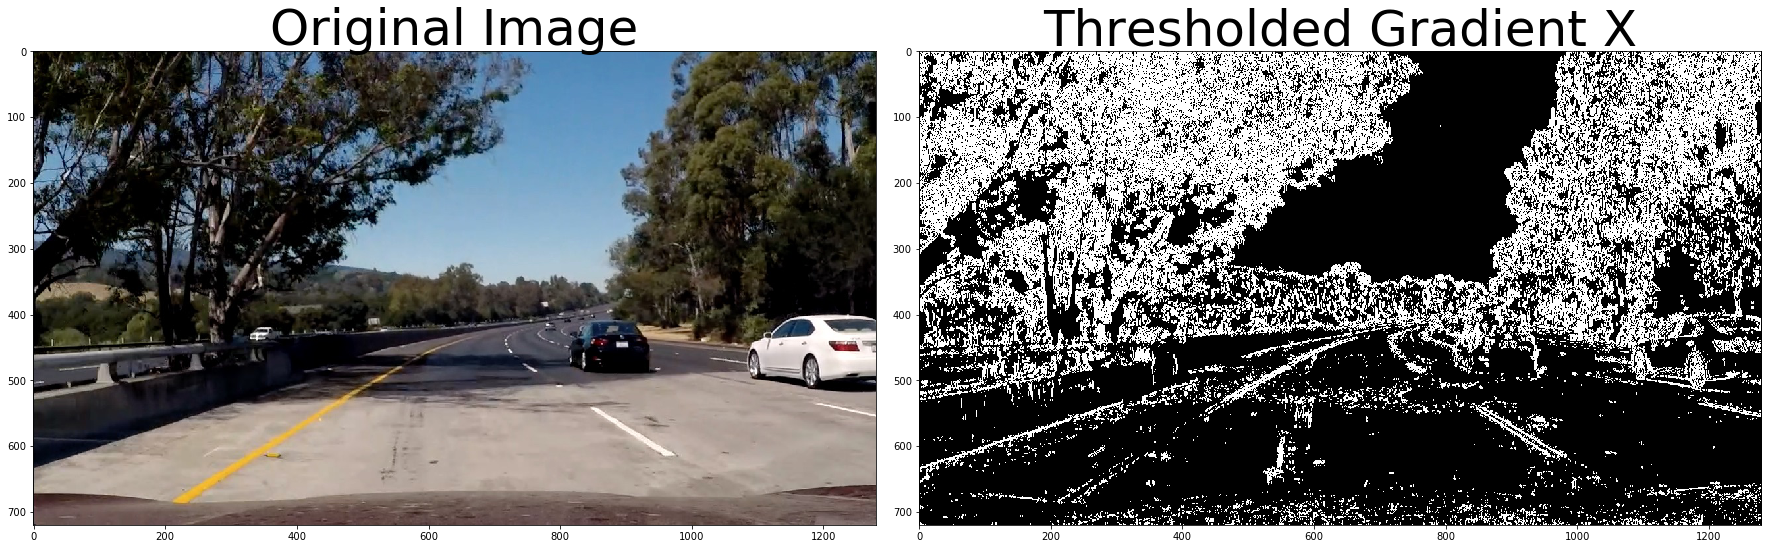

In [6]:
grad_binary = grad_threshold(image, orient='x', sobel_kernel = 7, \
                               grad_thresh=(5, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient X', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### gradient y

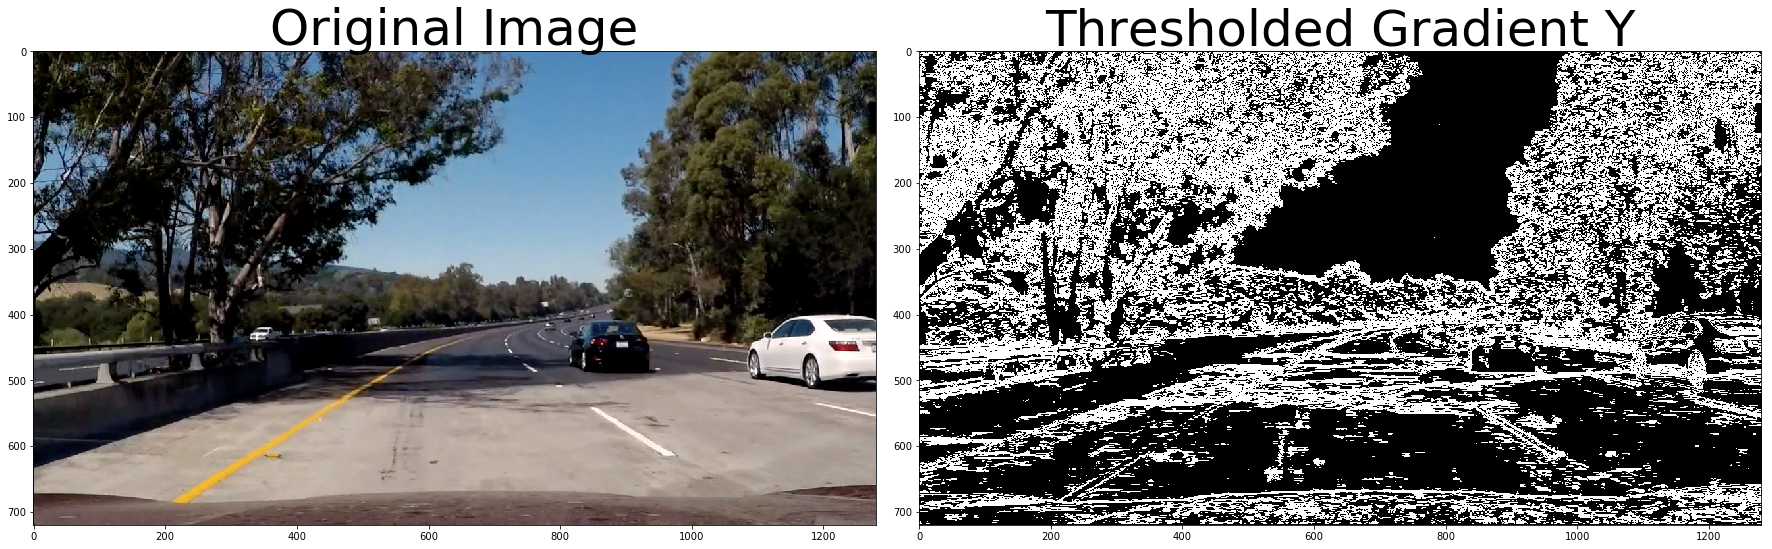

In [7]:
grad_binary = grad_threshold(image, orient='y', sobel_kernel = 7, \
                               grad_thresh=(5, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient Y', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### gradient magnitude

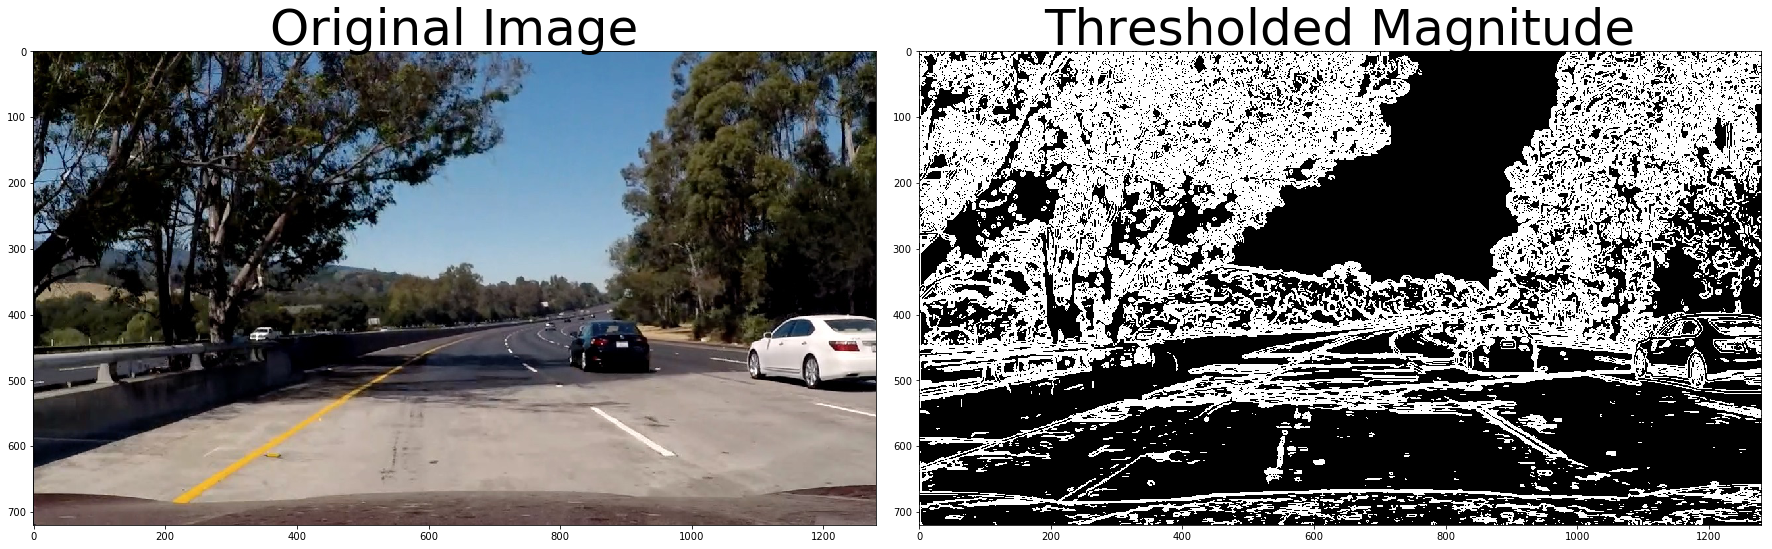

In [8]:
mag_binary = mag_threshold(image, sobel_kernel=7, mag_thresh=(10, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### gradient direction

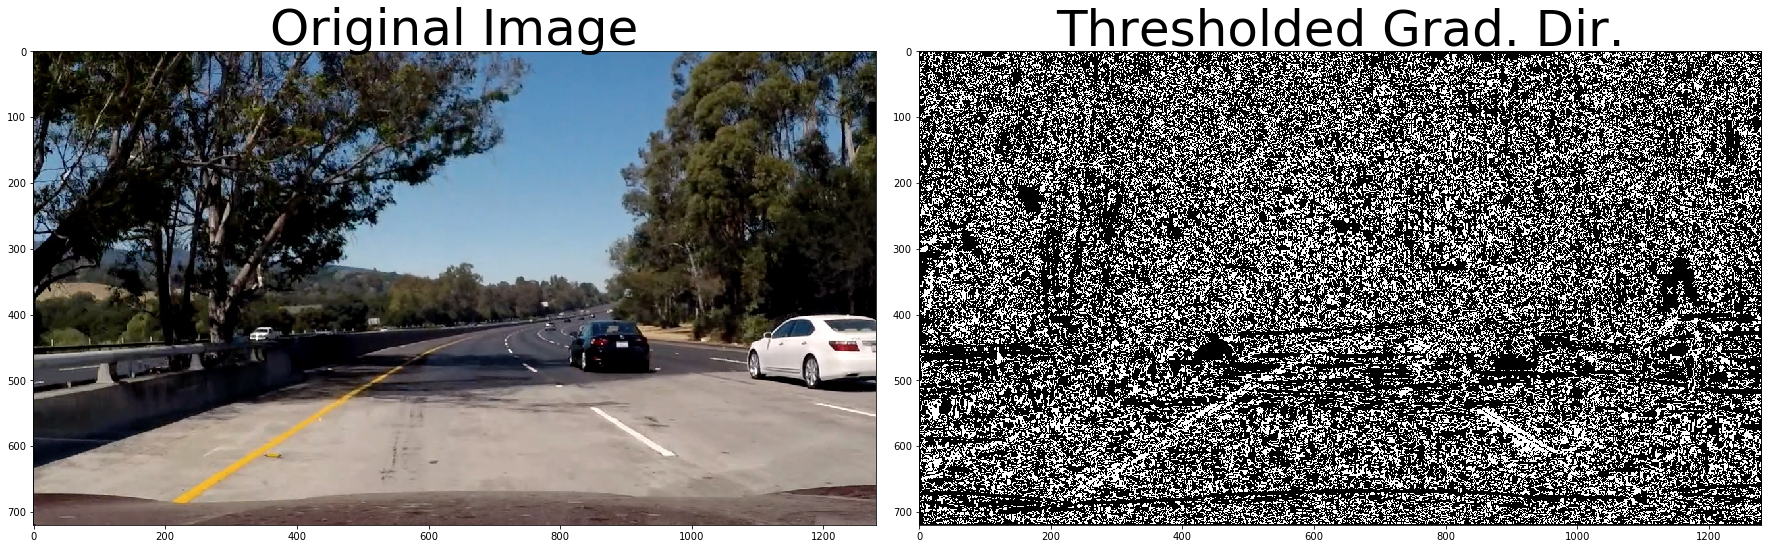

In [9]:
dir_binary = dir_threshold(image, sobel_kernel=7, dir_thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### combination gradient on shadow

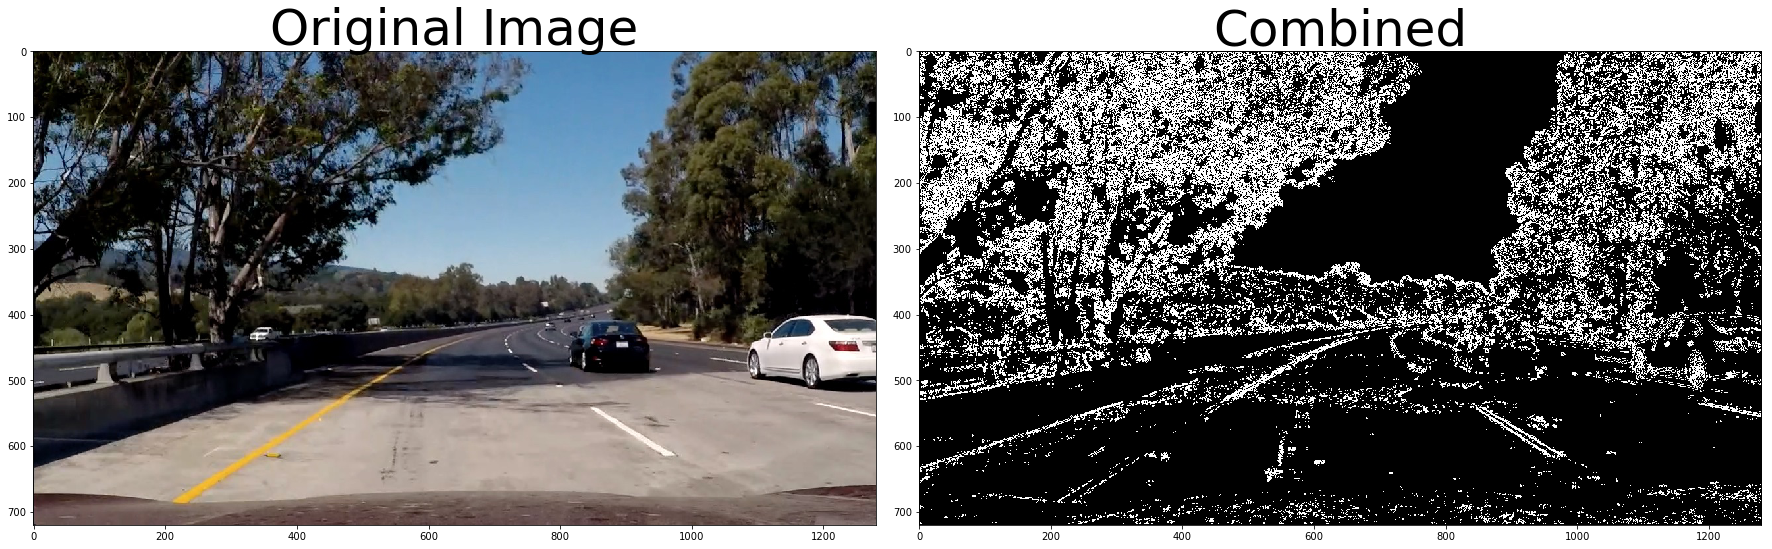

In [10]:
# Read in an image
#image = mpimg.imread('signs_vehicles_xygrad.png')
image = mpimg.imread('color-shadow-example.jpg')

# Choose a Sobel kernel size
#ksize = 3 # Choose a larger odd number to smooth gradient measurements
ksize = 3

# Apply each of the thresholding functions
gradx = grad_threshold(image, orient='x', sobel_kernel=ksize, \
                        #thresh=(5, 100))
                        grad_thresh=(5, 100))
grady = grad_threshold(image, orient='y', sobel_kernel=ksize, \
                        #thresh=(5, 100))
                        grad_thresh=(5, 100))
mag_binary = mag_threshold(image, sobel_kernel=ksize, \
                        #mag_thresh=(30, 100))
                        mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, \
                        #thresh=(0.7, 1.3))
                        dir_thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### combination gradient on signs

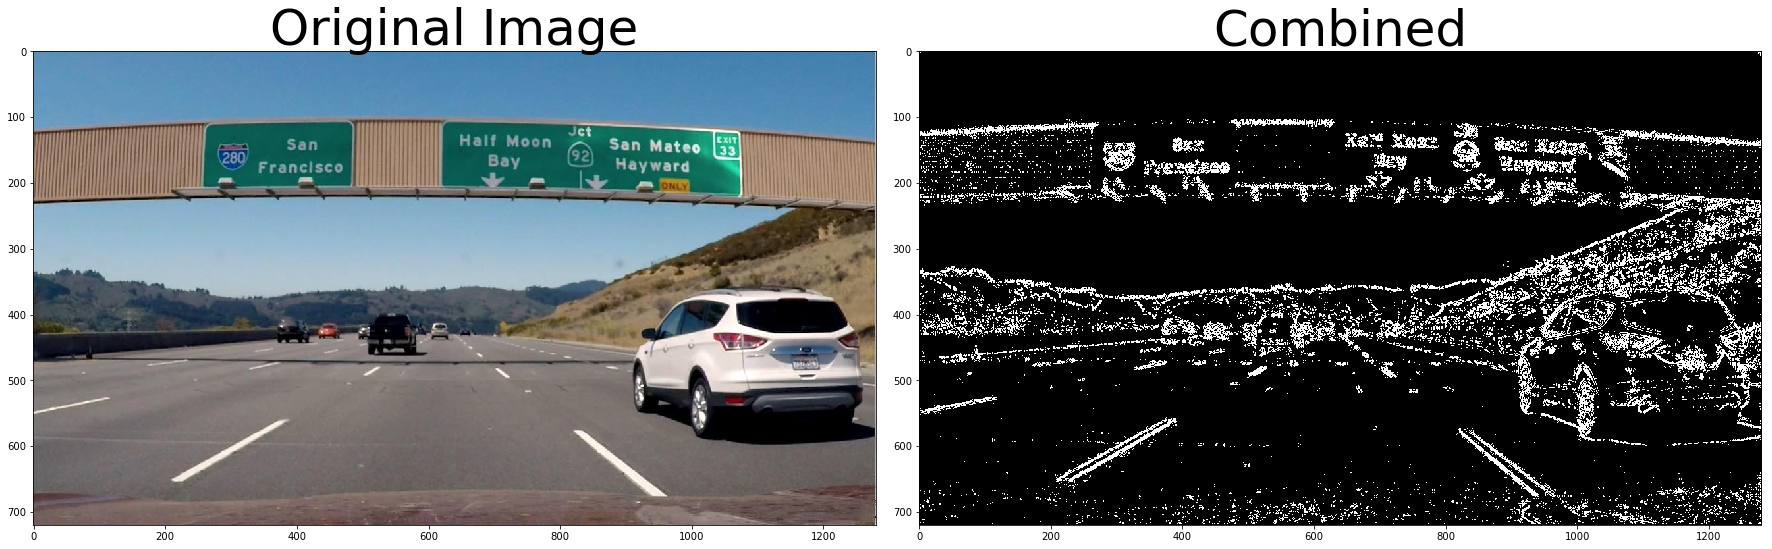

In [11]:
# Read in an image
image = mpimg.imread('signs_vehicles_xygrad.png')
#image = mpimg.imread('color-shadow-example.jpg')

# Choose a Sobel kernel size
#ksize = 3 # Choose a larger odd number to smooth gradient measurements
ksize = 3

# Apply each of the thresholding functions
gradx = grad_threshold(image, orient='x', sobel_kernel=ksize, \
                        #thresh=(5, 100))
                        grad_thresh=(5, 100))
grady = grad_threshold(image, orient='y', sobel_kernel=ksize, \
                        #thresh=(5, 100))
                        grad_thresh=(5, 100))
mag_binary = mag_threshold(image, sobel_kernel=ksize, \
                        #mag_thresh=(30, 100))
                        mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, \
                        #thresh=(0.7, 1.3))
                        dir_thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### combination color and gradient threshold

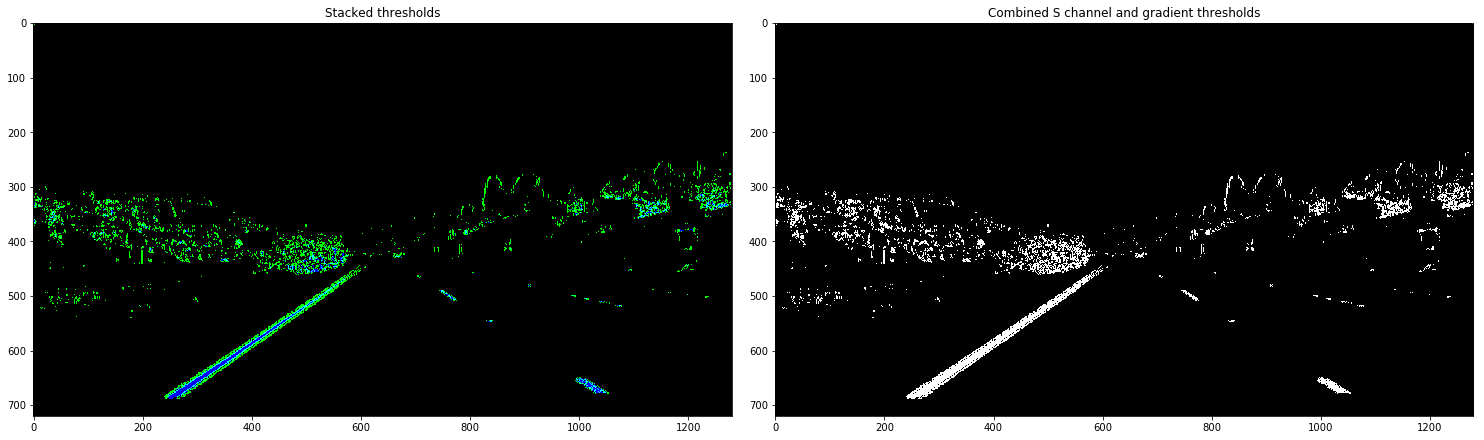

In [12]:
def color_gradient_threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    # scale up image
    combined_binary *= 255
    return color_binary, combined_binary

# Read in an image
#image = mpimg.imread('signs_vehicles_xygrad.png')
#image = mpimg.imread('color-shadow-example.jpg')
image = mpimg.imread('test_images/straight_lines1.jpg')

color_binary, combined_binary = color_gradient_threshold(image)

# Plotting thresholded images
f, (ax2, ax3) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()

#ax1.imshow(image)
#ax1.set_title('Original Image', fontsize=40)

ax2.set_title('Stacked thresholds')
ax2.imshow(color_binary)

ax3.set_title('Combined S channel and gradient thresholds')
ax3.imshow(combined_binary, cmap='gray')

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective transform

## Thresholded and warped image

(1280, 720)


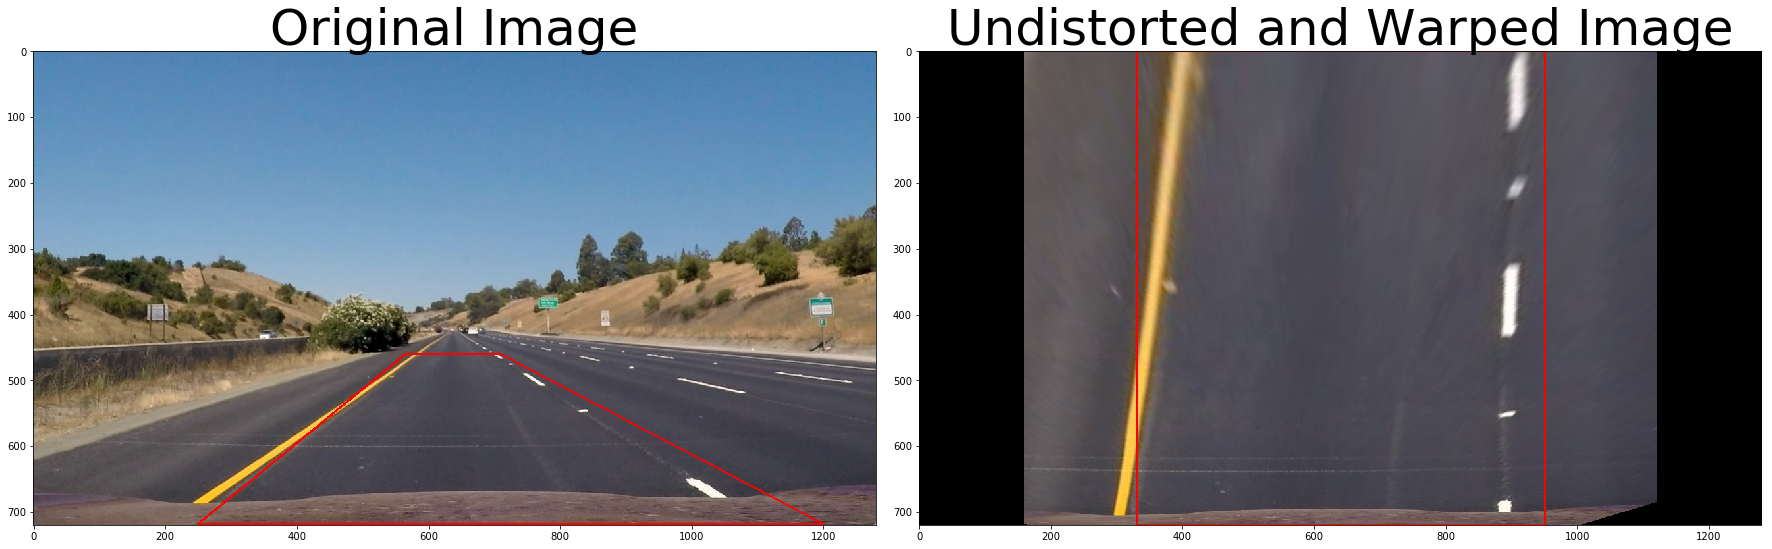

In [13]:
def perspective_transform(img):
    points_src = [[565,460],[710,460],[1200,718],[250,718]]
    #points_src = [[590,460],[700,460],[1150,720],[190,720]]
    src = np.float32(points_src)
    pts = np.array(points_src, np.int32)
    pts = pts.reshape((-1,1,2))
    img_src_pts = img.copy()
    cv2.polylines(img_src_pts,[pts],True,(255,0,0), 2)

    offsetx = 330
    #offsetx = 150
    offsety = 0
    #dst = np.float32([[535,0],[770,0],[770,720],[535,720]])
    points_dst = [[offsetx, offsety], [image_size[0]-offsetx, offsety], [image_size[0]-offsetx, image_size[1]-offsety], [offsetx, image_size[1]-offsety]]
    #points_dst = [[src[3][0]+offsetx, offsety], [src[2][0]-offsetx, offsety], src[2]-[offsetx, offsety], src[3]+[offsetx, offsety]]
    dst = np.float32(points_dst)
    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, image_size, flags=cv2.INTER_LINEAR)
    # region of interest
    warped[:, :int(2*warped.shape[0]/9)]=0
    warped[:, -int(2*warped.shape[0]/9):]=0
    warped_dst_pts = warped.copy()
    pts = np.array(points_dst, np.int32)
    pts = pts.reshape((-1,1,2))
    warped_dst_pts = cv2.polylines(warped_dst_pts, [pts],True,(255,0,0), 2)
    return img_src_pts, warped_dst_pts, warped

# Read in an image
#image = mpimg.imread('signs_vehicles_xygrad.png')
#image = mpimg.imread('color-shadow-example.jpg')
image = mpimg.imread('test_images/straight_lines1.jpg')
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
image_size = gray.shape[::-1]
print(image_size)

undistorted = cal_undistort(image, objpoints, imgpoints)
img = image.copy()
undistorted_src_pts, warped_dst_pts,\
    binary_warped = perspective_transform(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted_src_pts)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped_dst_pts)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [14]:
# Read in an image
#image = mpimg.imread('signs_vehicles_xygrad.png')
#image = mpimg.imread('color-shadow-example.jpg')
#image = mpimg.imread('test_images/straight_lines1.jpg')
#images = []
#images.append(mpimg.imread('test_images/straight_lines1.jpg'))
#images.append(mpimg.imread('color-shadow-example.jpg'))
#images.append(mpimg.imread('signs_vehicles_xygrad.png'))

#gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
#image_size = gray.shape[::-1]
#print(image_size)
def pipeline_test(image):
    undistorted = cal_undistort(image, objpoints, imgpoints)
    img = undistorted.copy()
    color_binary, combined_binary = color_gradient_threshold(img)
    img = cv2.cvtColor(combined_binary, cv2.COLOR_GRAY2BGR)
    return perspective_transform(img)

def pipeline(image):
    combined_undistorted_src_pts, warped_dst_pts, binary_warped = pipeline_test(image)
    return binary_warped

In [15]:
clip = VideoFileClip("project_video.mp4")
images = []
for frame in clip.iter_frames(progress_bar=True):
    images.append(frame)

100%|█████████▉| 1260/1261 [00:05<00:00, 225.31it/s]


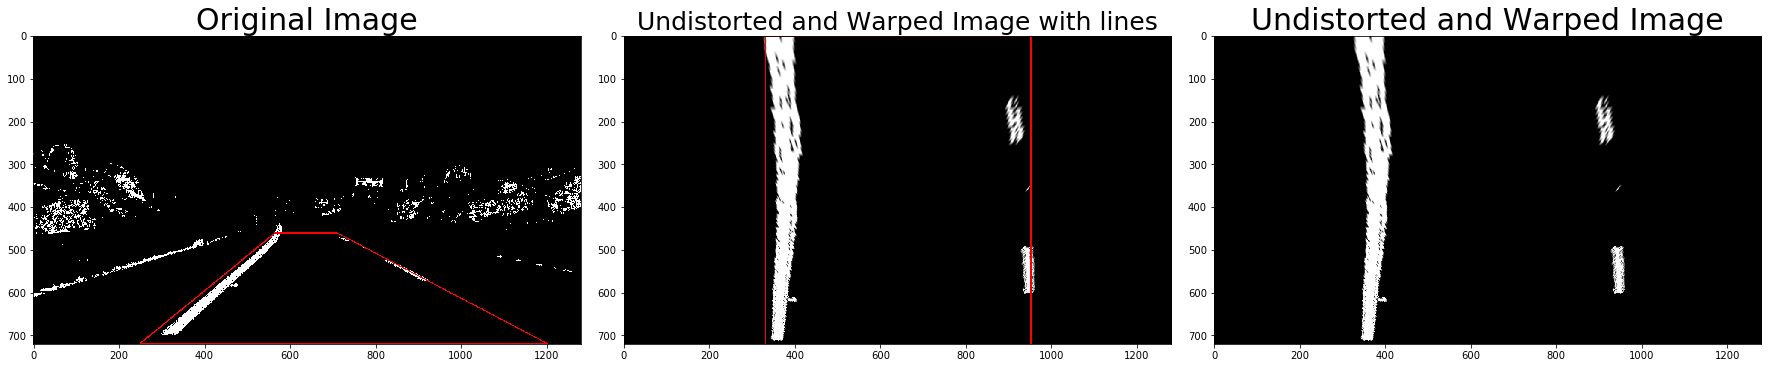

In [16]:
@interact
def thresholded_warped_test(i:(0,len(images)-1) = 0, images = fixed(images)):
    image = images[i]    
    combined_undistorted_src_pts, binary_warped_dst_pts, binary_warped\
    = pipeline_test(image)
    
    f, axes = plt.subplots(1, 3, figsize=(24, 9))
    ax1 = axes[0]
    ax2 = axes[1]
    ax3 = axes[2]
    f.tight_layout()
    ax1.imshow(combined_undistorted_src_pts)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(binary_warped_dst_pts)
    ax2.set_title('Undistorted and Warped Image with lines', fontsize=25)
    ax3.imshow(binary_warped, cmap = 'gray')
    ax3.set_title('Undistorted and Warped Image', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
#interact(thresholded_warped, image=images, objpoints = fixed(objpoints), imgpoints = fixed(imgpoints))
#thresholded_warped(images[0], objpoints, imgpoints)

#### video

####  visualization

In [17]:
clip = VideoFileClip("project_video.mp4")
lane_clip = clip.fl_image(pipeline)
lane_clip.write_videofile("project_video_result_warped.mp4", audio = False)

[MoviePy] >>>> Building video project_video_result_warped.mp4
[MoviePy] Writing video project_video_result_warped.mp4


100%|█████████▉| 1260/1261 [02:26<00:00, 10.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result_warped.mp4 



In [18]:
%%HTML
<video width="640" height="360" controls>
  <source src="project_video_result_warped.mp4" type="video/mp4">
</video>


## Detect lane lines

In [19]:
clip = VideoFileClip("project_video_result_warped.mp4")
images = []
for frame in clip.iter_frames(progress_bar=True):
    images.append(frame)

100%|█████████▉| 1260/1261 [00:04<00:00, 277.54it/s]


In [20]:
n = 15
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = deque([], maxlen = n)
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.recent_fits = deque([], maxlen = n)
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

### histogram

In [21]:
left = Line()
right = Line()
max_distance = 2.8
max_rel_fitx = 0.1
n_avg = 7

def histogram_test(binary_warped, nwindows = 9, margin = 100, minpix = 50):
    binary_warped = cv2.cvtColor(binary_warped, cv2.COLOR_BGR2GRAY)
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    #nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    #margin = 100
    # Set minimum number of pixels found to recenter window
    #minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and5 left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
        
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # update right lane
    if len(right.recent_fits) == 0:
        right.detected = True
        right.recent_xfitted.append(right_fitx)
        right.recent_fits.append(right_fit)
        right.current_fit = right_fit
        right.best_fit = right_fit
        right.bestx = right_fitx
    else:
        right.line_base_pos = (right_fit[0]*720.0**2 + right_fit[1]*720.0 \
                               + right_fit[2] - 640.0)*3.7/600.0
        right.diffs = right_fitx - right.bestx
        rel_diff = np.linalg.norm(right.diffs)/np.linalg.norm(right.bestx)
        #print(right.line_base_pos)
        #print(np.linalg.norm(right_fitx))
        #print(np.linalg.norm(right.bestx))
        #print(rel_diff)
        if abs(right.line_base_pos) <= max_distance \
                    and rel_diff < max_rel_fitx :
            right.detected = True
            right.recent_xfitted.append(right_fitx)
            right.bestx = np.average(np.asarray(right.recent_xfitted), 0)
            right.recent_fits.append(right_fit)
            right.best_fit = np.average(np.array(right.recent_fits), 0)
            right.current_fit = right_fit
        else:
            print('bad')
            right.detected = False
            right.recent_fits.pop()
            right.recent_xfitted.pop()
            if len(right.recent_fits) > 0:
                right.bestx = np.average(np.asarray(right.recent_xfitted)[-n_avg:], 0)
                right.best_fit = np.average(np.array(right.recent_fits)[-n_avg:], 0)
                right.current_fit = right.best_fit
        print(len(right.recent_fits)) #else:
                #right.bestx = right_fitx
                #right.best_fit = right_fit
                #right.current_fit = right.best_fit

        right.allx = rightx
        right.ally = righty
        right_fit = right.best_fit
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
            
            
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    plt.ioff()
    a = plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    out_img = a.get_array()
    plt.ion()
    return out_img

def histogram2_test(warped, window_width = 50, window_height = 80, margin = 100):
    #warped = mpimg.imread('warped_example.jpg')
    # window settings
    #window_width = 50 
    #window_height = 80 # Break image into 9 vertical layers since image height is 720
    #margin = 100 # How much to slide left and right for searching
    #window_width = 50
    #window_height = 80 # Break image into 9 vertical layers since image height is 720
    #margin = 100 # How much to slide left and right for searching
    
    def window_mask(width, height, img_ref, center,level):
        output = np.zeros_like(img_ref)
        output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
        return output

    def find_window_centroids(image, window_width, window_height, margin):

        window_centroids = [] # Store the (left,right) window centroid positions per level
        window = np.ones(window_width) # Create our window template that we will use for convolutions

        # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
        # and then np.convolve the vertical image slice with the window template 

        # Sum quarter bottom of image to get slice, could use a different ratio
        l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
        l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
        r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
        r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)

        # Add what we found for the first layer
        window_centroids.append((l_center,r_center))

        # Go through each layer looking for max pixel locations
        for level in range(1,(int)(warped.shape[0]/window_height)):
            # convolve the window into the vertical slice of the image
            image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
            conv_signal = np.convolve(window, image_layer)
            # Find the best left centroid by using past left center as a reference
            # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
            offset = window_width/2
            l_min_index = int(max(l_center+offset-margin,0))
            l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
            # Find the best right centroid by using past right center as a reference
            r_min_index = int(max(r_center+offset-margin,0))
            r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
            # Add what we found for that layer
            window_centroids.append((l_center,r_center))

        return window_centroids

    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    return output

### visualization

(720, 1280)


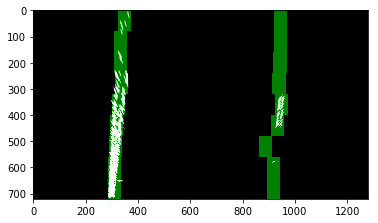

In [23]:
@interact
def detect_lane_lines_test(i:(0,len(images)-1) = 600, images = fixed(images),  window_width:(10,150) = 50, window_height:(10,200) = 80, margin:(10,250) = 100):
    image = images[i]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    print(image.shape)
    out_img = histogram2_test(image)

    plt.imshow(out_img)
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

(720, 1280, 3)
15


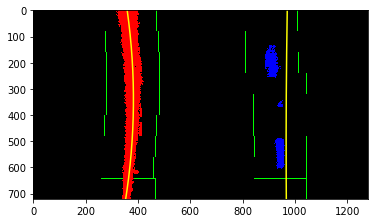

In [22]:
left = Line()
right = Line()
@interact
def detect_lane_lines_test(i:(0,len(images)-1) = 0, images = fixed(images), nwindows:(1,30) = 9, margin:(10,300) = 100, minpix:(10,300) = 50):
    image = images[i]
    print(image.shape)
    out_img = histogram_test(image, nwindows, margin, minpix)

    plt.imshow(out_img)
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

In [ ]:
left = Line()
right = Line()
for image in images
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    out_img = histogram2_test(image)


2
[MoviePy] >>>> Building video project_video_result_detect_lane_lines1.mp4
[MoviePy] Writing video project_video_result_detect_lane_lines1.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

3


  0%|          | 2/1261 [00:00<01:37, 12.88it/s]

4
5


  0%|          | 4/1261 [00:00<01:34, 13.30it/s]

6


  0%|          | 6/1261 [00:00<01:31, 13.77it/s]

7
8
9
10


  1%|          | 10/1261 [00:00<01:24, 14.88it/s]

11
12
13
14


  1%|          | 14/1261 [00:00<01:21, 15.39it/s]

15
15
15
15


  1%|▏         | 18/1261 [00:01<01:18, 15.87it/s]

15
15
15
15


  2%|▏         | 22/1261 [00:01<01:17, 15.89it/s]

15
15
15
15


  2%|▏         | 26/1261 [00:01<01:19, 15.44it/s]

15
15
15
15


  2%|▏         | 30/1261 [00:01<01:18, 15.70it/s]

15
15
15
15


  3%|▎         | 34/1261 [00:02<01:18, 15.64it/s]

15
15
15
15


  3%|▎         | 36/1261 [00:02<01:19, 15.48it/s]

15
15


  3%|▎         | 40/1261 [00:02<01:27, 13.92it/s]

15
15
15
15


  3%|▎         | 44/1261 [00:02<01:25, 14.31it/s]

15
15
15


  4%|▍         | 48/1261 [00:03<01:23, 14.50it/s]

15
15
15


  4%|▍         | 50/1261 [00:03<01:24, 14.26it/s]

15
15
15


  4%|▍         | 54/1261 [00:03<01:28, 13.70it/s]

15
15
15


  4%|▍         | 56/1261 [00:03<01:28, 13.61it/s]

15
15
15


  5%|▍         | 60/1261 [00:04<01:29, 13.39it/s]

15
15
15


  5%|▍         | 62/1261 [00:04<01:31, 13.15it/s]

15
15
15


  5%|▌         | 66/1261 [00:04<01:27, 13.58it/s]

15
15
15


  5%|▌         | 68/1261 [00:04<01:27, 13.56it/s]

15
15
15


  6%|▌         | 72/1261 [00:04<01:22, 14.41it/s]

15
15
15


  6%|▌         | 74/1261 [00:05<01:22, 14.37it/s]

15
15
15
15


  6%|▌         | 78/1261 [00:05<01:20, 14.63it/s]

15
15
15


  7%|▋         | 82/1261 [00:05<01:22, 14.35it/s]

15
15
15


  7%|▋         | 84/1261 [00:05<01:23, 14.07it/s]

15
15
15


  7%|▋         | 86/1261 [00:05<01:25, 13.75it/s]

15
15
15


  7%|▋         | 90/1261 [00:06<01:29, 13.12it/s]

15
15
15


  7%|▋         | 94/1261 [00:06<01:24, 13.85it/s]

15
15
15
15

  8%|▊         | 96/1261 [00:06<01:25, 13.65it/s]


15
15


  8%|▊         | 100/1261 [00:06<01:23, 13.84it/s]

15
15
15


  8%|▊         | 102/1261 [00:07<01:25, 13.56it/s]

15
15
15


  8%|▊         | 106/1261 [00:07<01:23, 13.89it/s]

15
15
15


  9%|▊         | 108/1261 [00:07<01:27, 13.19it/s]

15
15
15


  9%|▉         | 112/1261 [00:07<01:25, 13.45it/s]

15
15
15


  9%|▉         | 114/1261 [00:08<01:25, 13.40it/s]

15
15
15


  9%|▉         | 118/1261 [00:08<01:21, 13.94it/s]

15
15
15


 10%|▉         | 120/1261 [00:08<01:19, 14.38it/s]

15
15
15
15


 10%|▉         | 124/1261 [00:08<01:21, 14.02it/s]

15
15
15


 10%|█         | 128/1261 [00:09<01:21, 13.87it/s]

15
15
15


 10%|█         | 130/1261 [00:09<01:22, 13.69it/s]

15
15
15


 11%|█         | 134/1261 [00:09<01:23, 13.48it/s]

15
15
15


 11%|█         | 136/1261 [00:09<01:21, 13.81it/s]

15
15
15


 11%|█         | 138/1261 [00:09<01:23, 13.42it/s]

15
15
15


 11%|█▏        | 142/1261 [00:10<01:26, 12.92it/s]

15
15
15


 12%|█▏        | 146/1261 [00:10<01:22, 13.50it/s]

15
15
15


 12%|█▏        | 148/1261 [00:10<01:24, 13.20it/s]

15
15
15


 12%|█▏        | 152/1261 [00:10<01:24, 13.18it/s]

15
15
15


 12%|█▏        | 154/1261 [00:10<01:24, 13.07it/s]

15
15
15


 12%|█▏        | 156/1261 [00:11<01:22, 13.33it/s]

15
15
15


 13%|█▎        | 160/1261 [00:11<01:25, 12.80it/s]

15
15
15


 13%|█▎        | 164/1261 [00:11<01:23, 13.08it/s]

15
15
15


 13%|█▎        | 166/1261 [00:11<01:22, 13.29it/s]

15
15
15


 13%|█▎        | 170/1261 [00:12<01:22, 13.16it/s]

15
15
15


 14%|█▎        | 172/1261 [00:12<01:24, 12.89it/s]

15
15
15


 14%|█▍        | 176/1261 [00:12<01:24, 12.84it/s]

15
15
15


 14%|█▍        | 178/1261 [00:12<01:24, 12.76it/s]

15
15
15


 14%|█▍        | 182/1261 [00:13<01:20, 13.47it/s]

15
15
15


 15%|█▍        | 184/1261 [00:13<01:21, 13.17it/s]

15
15
15


 15%|█▍        | 186/1261 [00:13<01:22, 12.97it/s]

15
15
15


 15%|█▌        | 190/1261 [00:13<01:26, 12.32it/s]

15
15
15


 15%|█▌        | 194/1261 [00:14<01:23, 12.77it/s]

15
15
15


 16%|█▌        | 196/1261 [00:14<01:25, 12.49it/s]

15
15
15


 16%|█▌        | 198/1261 [00:14<01:24, 12.65it/s]

15
15
15


 16%|█▌        | 202/1261 [00:14<01:20, 13.18it/s]

15
15
15


 16%|█▋        | 206/1261 [00:14<01:15, 13.88it/s]

15
15
15


 16%|█▋        | 208/1261 [00:15<01:17, 13.53it/s]

15
15
15


 17%|█▋        | 212/1261 [00:15<01:14, 14.16it/s]

15
15
15
15


 17%|█▋        | 214/1261 [00:15<01:12, 14.35it/s]

15
15
15


 17%|█▋        | 218/1261 [00:15<01:14, 13.92it/s]

15
15
15
15


 18%|█▊        | 222/1261 [00:16<01:12, 14.41it/s]

15
15
15
15


 18%|█▊        | 226/1261 [00:16<01:11, 14.38it/s]

15
15
15


 18%|█▊        | 230/1261 [00:16<01:11, 14.35it/s]

15
15
15


 18%|█▊        | 232/1261 [00:16<01:12, 14.12it/s]

15
15
15


 19%|█▊        | 234/1261 [00:16<01:18, 13.01it/s]

15
15
15


 19%|█▉        | 238/1261 [00:17<01:17, 13.24it/s]

15
15
15


 19%|█▉        | 242/1261 [00:17<01:16, 13.39it/s]

15
15
15


 19%|█▉        | 244/1261 [00:17<01:13, 13.78it/s]

15
15
15


 20%|█▉        | 246/1261 [00:17<01:16, 13.20it/s]

15
15
15


 20%|█▉        | 250/1261 [00:18<01:19, 12.66it/s]

15
15
15


 20%|█▉        | 252/1261 [00:18<01:23, 12.15it/s]

15
15
15


 20%|██        | 256/1261 [00:18<01:28, 11.39it/s]

15
15
15


 20%|██        | 258/1261 [00:18<01:28, 11.30it/s]

15
15
15


 21%|██        | 262/1261 [00:19<01:26, 11.61it/s]

15
15
15


 21%|██        | 264/1261 [00:19<01:25, 11.72it/s]

15
15
15


 21%|██▏       | 268/1261 [00:19<01:31, 10.81it/s]

15
15


 21%|██▏       | 270/1261 [00:20<01:33, 10.54it/s]

15
15
15


 22%|██▏       | 272/1261 [00:20<01:35, 10.38it/s]

15
15
15


 22%|██▏       | 276/1261 [00:20<01:36, 10.22it/s]

15
15
15


 22%|██▏       | 278/1261 [00:20<01:31, 10.75it/s]

15
15
15


 22%|██▏       | 282/1261 [00:21<01:33, 10.43it/s]

15
15


 23%|██▎       | 284/1261 [00:21<01:33, 10.42it/s]

15
15


 23%|██▎       | 286/1261 [00:21<01:36, 10.10it/s]

15
15
15


 23%|██▎       | 290/1261 [00:21<01:24, 11.45it/s]

15
15
15


 23%|██▎       | 292/1261 [00:22<01:20, 12.01it/s]

15
15
15


 23%|██▎       | 294/1261 [00:22<01:19, 12.15it/s]

15
15
15


 24%|██▎       | 298/1261 [00:22<01:20, 11.93it/s]

15
15
15


 24%|██▍       | 300/1261 [00:22<01:17, 12.36it/s]

15
15
15


 24%|██▍       | 304/1261 [00:23<01:28, 10.83it/s]

15
15


 24%|██▍       | 306/1261 [00:23<01:26, 11.04it/s]

15
15
15


 24%|██▍       | 308/1261 [00:23<01:25, 11.19it/s]

15
15
15


 25%|██▍       | 312/1261 [00:23<01:20, 11.78it/s]

15
15
15


 25%|██▍       | 314/1261 [00:23<01:18, 11.99it/s]

15
15
15


 25%|██▌       | 318/1261 [00:24<01:19, 11.79it/s]

15
15
15


 25%|██▌       | 320/1261 [00:24<01:18, 11.92it/s]

15
15
15


 26%|██▌       | 324/1261 [00:24<01:17, 12.16it/s]

15
15
15


 26%|██▌       | 326/1261 [00:24<01:24, 11.05it/s]

15
15


 26%|██▌       | 329/1261 [00:25<01:41,  9.20it/s]

15
15


 26%|██▌       | 330/1261 [00:25<01:40,  9.25it/s]

15
15


 26%|██▋       | 333/1261 [00:25<01:51,  8.31it/s]

15
15


 27%|██▋       | 335/1261 [00:26<01:56,  7.98it/s]

15
15


 27%|██▋       | 337/1261 [00:26<01:57,  7.84it/s]

15
15


 27%|██▋       | 339/1261 [00:26<01:57,  7.87it/s]

15
15


 27%|██▋       | 341/1261 [00:26<01:48,  8.45it/s]

15
15


 27%|██▋       | 343/1261 [00:27<01:50,  8.28it/s]

15
15


 27%|██▋       | 345/1261 [00:27<01:53,  8.06it/s]

15
15


 27%|██▋       | 346/1261 [00:27<01:53,  8.09it/s]

15
15


 28%|██▊       | 348/1261 [00:27<01:54,  8.00it/s]

15
15


 28%|██▊       | 350/1261 [00:28<02:01,  7.47it/s]

15
15


 28%|██▊       | 352/1261 [00:28<02:01,  7.47it/s]

15
15


 28%|██▊       | 354/1261 [00:28<02:02,  7.39it/s]

15
15


 28%|██▊       | 356/1261 [00:28<01:49,  8.25it/s]

15
15
15


 29%|██▊       | 360/1261 [00:29<01:32,  9.70it/s]

15
15
15


 29%|██▊       | 362/1261 [00:29<01:29, 10.00it/s]

15
15
15


 29%|██▉       | 366/1261 [00:29<01:20, 11.09it/s]

15
15
15


 29%|██▉       | 368/1261 [00:29<01:17, 11.47it/s]

15
15
15


 30%|██▉       | 372/1261 [00:30<01:19, 11.21it/s]

15
15


 30%|██▉       | 374/1261 [00:30<01:19, 11.13it/s]

15
15
15


 30%|██▉       | 376/1261 [00:30<01:20, 10.99it/s]

15
15
15


 30%|███       | 380/1261 [00:30<01:18, 11.24it/s]

15
15
15


 30%|███       | 382/1261 [00:31<01:22, 10.65it/s]

15
15
15


 31%|███       | 386/1261 [00:31<01:23, 10.45it/s]

15
15
15


 31%|███       | 388/1261 [00:31<01:22, 10.64it/s]

15
15
15


 31%|███       | 392/1261 [00:31<01:20, 10.73it/s]

15
15
15


 31%|███       | 394/1261 [00:32<01:22, 10.55it/s]

15
15
15


 32%|███▏      | 398/1261 [00:32<01:20, 10.77it/s]

15
15
15


 32%|███▏      | 400/1261 [00:32<01:21, 10.56it/s]

15
15
15


 32%|███▏      | 404/1261 [00:33<01:14, 11.57it/s]

15
15
15


 32%|███▏      | 406/1261 [00:33<01:13, 11.61it/s]

15
15
15


 33%|███▎      | 410/1261 [00:33<01:12, 11.82it/s]

15
15
15


 33%|███▎      | 412/1261 [00:33<01:12, 11.69it/s]

15
15
15


 33%|███▎      | 416/1261 [00:34<01:13, 11.46it/s]

15
15
15


 33%|███▎      | 418/1261 [00:34<01:13, 11.53it/s]

15
15
15


 33%|███▎      | 422/1261 [00:34<01:12, 11.64it/s]

15
15
15


 34%|███▎      | 424/1261 [00:34<01:12, 11.47it/s]

15
15
15


 34%|███▍      | 428/1261 [00:35<01:10, 11.78it/s]

15
15
15


 34%|███▍      | 430/1261 [00:35<01:11, 11.61it/s]

15
15
15


 34%|███▍      | 434/1261 [00:35<01:11, 11.49it/s]

15
15
15


 35%|███▍      | 436/1261 [00:35<01:09, 11.80it/s]

15
15
15


 35%|███▍      | 440/1261 [00:36<01:10, 11.69it/s]

15
15
15


 35%|███▌      | 442/1261 [00:36<01:10, 11.60it/s]

15
15
15


 35%|███▌      | 446/1261 [00:36<01:10, 11.54it/s]

15
15
15


 36%|███▌      | 448/1261 [00:36<01:08, 11.82it/s]

15
15
15


 36%|███▌      | 452/1261 [00:37<01:05, 12.37it/s]

15
15
15


 36%|███▌      | 456/1261 [00:37<01:02, 12.80it/s]

15
15
15


 36%|███▋      | 458/1261 [00:37<01:01, 12.99it/s]

15
15
15


 37%|███▋      | 462/1261 [00:37<01:01, 13.04it/s]

15
15
15


 37%|███▋      | 464/1261 [00:38<01:00, 13.17it/s]

15
15
15


 37%|███▋      | 468/1261 [00:38<00:59, 13.39it/s]

15
15
15


 37%|███▋      | 470/1261 [00:38<01:01, 12.90it/s]

15
15
15


 37%|███▋      | 472/1261 [00:38<01:02, 12.70it/s]

15
15
15


 38%|███▊      | 476/1261 [00:39<01:03, 12.35it/s]

15
15
15


 38%|███▊      | 478/1261 [00:39<01:03, 12.24it/s]

15
15
15


 38%|███▊      | 482/1261 [00:39<01:03, 12.35it/s]

15
15
15


 38%|███▊      | 484/1261 [00:39<01:01, 12.54it/s]

15
15
15


 39%|███▊      | 488/1261 [00:40<01:02, 12.34it/s]

15
15
15


 39%|███▉      | 490/1261 [00:40<01:04, 12.03it/s]

15
15
15


 39%|███▉      | 494/1261 [00:40<01:04, 11.81it/s]

15
15
15


 39%|███▉      | 496/1261 [00:40<01:03, 12.08it/s]

15
15
15


 40%|███▉      | 500/1261 [00:41<01:08, 11.08it/s]

15
15


 40%|███▉      | 502/1261 [00:41<01:08, 11.06it/s]

15
15
15


 40%|███▉      | 504/1261 [00:41<01:08, 11.06it/s]

15
15
15


 40%|████      | 508/1261 [00:41<01:07, 11.23it/s]

15
15
15


 40%|████      | 510/1261 [00:41<01:05, 11.41it/s]

15
15
15


 41%|████      | 514/1261 [00:42<01:02, 11.86it/s]

15
15
15


 41%|████      | 518/1261 [00:42<01:00, 12.27it/s]

15
15
15


 41%|████      | 520/1261 [00:42<01:00, 12.18it/s]

15
15
15


 41%|████▏     | 522/1261 [00:42<01:01, 12.11it/s]

15
15
15


 42%|████▏     | 526/1261 [00:43<01:01, 11.90it/s]

15
15
15


 42%|████▏     | 528/1261 [00:43<00:59, 12.26it/s]

15
15
15


 42%|████▏     | 532/1261 [00:43<01:02, 11.58it/s]

15
15
15


 42%|████▏     | 534/1261 [00:43<01:03, 11.45it/s]

15
15
15


 43%|████▎     | 538/1261 [00:44<01:00, 11.89it/s]

15
15
15


 43%|████▎     | 540/1261 [00:44<01:01, 11.75it/s]

15
15
15


 43%|████▎     | 544/1261 [00:44<01:00, 11.92it/s]

15
15
15


 43%|████▎     | 548/1261 [00:45<00:57, 12.45it/s]

15
15
15


 44%|████▎     | 550/1261 [00:45<00:55, 12.71it/s]

15
15
15


 44%|████▍     | 552/1261 [00:45<00:55, 12.76it/s]

15
15
15


 44%|████▍     | 556/1261 [00:45<00:54, 12.95it/s]

15
15
15


 44%|████▍     | 558/1261 [00:45<00:53, 13.12it/s]

15
15
15


 45%|████▍     | 562/1261 [00:46<00:55, 12.54it/s]

15
15
15


 45%|████▍     | 566/1261 [00:46<00:54, 12.86it/s]

15
15
15


 45%|████▌     | 568/1261 [00:46<00:53, 12.89it/s]

15
15
15


 45%|████▌     | 570/1261 [00:46<01:01, 11.22it/s]

15
15


 46%|████▌     | 574/1261 [00:47<00:54, 12.52it/s]

15
15
15


 46%|████▌     | 576/1261 [00:47<00:54, 12.65it/s]

15
15
15


 46%|████▌     | 578/1261 [00:47<00:53, 12.79it/s]

15
15
15


 46%|████▌     | 582/1261 [00:47<00:56, 11.95it/s]

15
15
15


 46%|████▋     | 584/1261 [00:48<00:57, 11.82it/s]

15
15
15


 47%|████▋     | 588/1261 [00:48<00:57, 11.71it/s]

15
15
15


 47%|████▋     | 590/1261 [00:48<00:55, 12.01it/s]

15
15
15


 47%|████▋     | 594/1261 [00:48<00:56, 11.89it/s]

15
15
15


 47%|████▋     | 596/1261 [00:49<00:57, 11.55it/s]

15
15
15


 48%|████▊     | 600/1261 [00:49<00:58, 11.35it/s]

15
15
15


 48%|████▊     | 604/1261 [00:49<00:53, 12.23it/s]

15
15
15


 48%|████▊     | 606/1261 [00:49<00:52, 12.37it/s]

15
15
15


 48%|████▊     | 608/1261 [00:50<00:52, 12.52it/s]

15
bad
14
bad
13


 49%|████▊     | 612/1261 [00:50<00:52, 12.35it/s]

bad
12
13
14


 49%|████▉     | 616/1261 [00:50<00:50, 12.76it/s]

15
15
15


 49%|████▉     | 618/1261 [00:50<00:51, 12.55it/s]

15
15
15


 49%|████▉     | 620/1261 [00:50<00:51, 12.36it/s]

15
15
15


 49%|████▉     | 624/1261 [00:51<00:51, 12.28it/s]

15
15
15


 50%|████▉     | 626/1261 [00:51<00:51, 12.27it/s]

15
15
15


 50%|████▉     | 630/1261 [00:51<00:52, 12.00it/s]

15
15
15


 50%|█████     | 632/1261 [00:51<00:52, 11.94it/s]

15
15
15


 50%|█████     | 636/1261 [00:52<00:53, 11.79it/s]

15
15
15


 51%|█████     | 638/1261 [00:52<00:51, 12.08it/s]

15
15
15


 51%|█████     | 642/1261 [00:52<00:51, 12.02it/s]

15
15
15


 51%|█████     | 646/1261 [00:53<00:49, 12.33it/s]

15
15
15


 51%|█████▏    | 648/1261 [00:53<00:49, 12.44it/s]

15
15
15


 52%|█████▏    | 650/1261 [00:53<00:49, 12.41it/s]

15
15
15


 52%|█████▏    | 654/1261 [00:53<00:51, 11.85it/s]

15
15
15


 52%|█████▏    | 658/1261 [00:54<00:49, 12.19it/s]

15
15
15


 52%|█████▏    | 660/1261 [00:54<00:49, 12.03it/s]

15
15
15


 52%|█████▏    | 662/1261 [00:54<00:49, 12.13it/s]

15
15
15


 53%|█████▎    | 666/1261 [00:54<00:49, 12.02it/s]

15
15
15


 53%|█████▎    | 668/1261 [00:54<00:49, 12.00it/s]

15
15
15


 53%|█████▎    | 672/1261 [00:55<00:53, 11.00it/s]

15
15


 53%|█████▎    | 674/1261 [00:55<00:56, 10.45it/s]

15
15


 54%|█████▎    | 676/1261 [00:55<00:56, 10.29it/s]

15
15


 54%|█████▍    | 678/1261 [00:55<00:56, 10.27it/s]

15
15
15


 54%|█████▍    | 680/1261 [00:56<00:52, 11.08it/s]

15
15
15


 54%|█████▍    | 684/1261 [00:56<00:49, 11.57it/s]

15
15
15


 54%|█████▍    | 686/1261 [00:56<00:48, 11.86it/s]

15
15
15


 55%|█████▍    | 690/1261 [00:56<00:50, 11.27it/s]

15
15


 55%|█████▍    | 692/1261 [00:57<00:50, 11.28it/s]

15
15
15


 55%|█████▌    | 694/1261 [00:57<00:52, 10.74it/s]

15
15


 55%|█████▌    | 696/1261 [00:57<00:52, 10.80it/s]

15
15
15


 56%|█████▌    | 700/1261 [00:57<00:51, 10.93it/s]

15
15
15


 56%|█████▌    | 702/1261 [00:58<00:50, 11.04it/s]

15
15
15


 56%|█████▌    | 706/1261 [00:58<00:49, 11.20it/s]

15
15
15


 56%|█████▌    | 708/1261 [00:58<00:49, 11.13it/s]

15
15
15


 56%|█████▋    | 712/1261 [00:58<00:50, 10.95it/s]

15
15
15


 57%|█████▋    | 714/1261 [00:59<00:49, 11.08it/s]

bad
14
15
15


 57%|█████▋    | 718/1261 [00:59<00:46, 11.63it/s]

15
15
15


 57%|█████▋    | 720/1261 [00:59<00:45, 11.86it/s]

15
15
15


 57%|█████▋    | 724/1261 [00:59<00:45, 11.77it/s]

15
15
15


 58%|█████▊    | 726/1261 [01:00<00:44, 11.97it/s]

15
bad
14
15


 58%|█████▊    | 730/1261 [01:00<00:44, 11.99it/s]

15
15
15


 58%|█████▊    | 732/1261 [01:00<00:44, 12.01it/s]

15
15
15


 58%|█████▊    | 736/1261 [01:01<00:50, 10.48it/s]

15
15
15
15


 59%|█████▊    | 739/1261 [01:01<01:02,  8.40it/s]

15
15


 59%|█████▉    | 741/1261 [01:01<01:12,  7.20it/s]

15
15


 59%|█████▉    | 743/1261 [01:02<01:12,  7.14it/s]

15
15


 59%|█████▉    | 745/1261 [01:02<01:13,  6.98it/s]

15
15


 59%|█████▉    | 748/1261 [01:02<01:07,  7.58it/s]

15
15


 59%|█████▉    | 750/1261 [01:02<01:06,  7.72it/s]

15
15


 60%|█████▉    | 751/1261 [01:03<01:08,  7.41it/s]

15
15


 60%|█████▉    | 753/1261 [01:03<01:12,  7.01it/s]

15
15


 60%|█████▉    | 755/1261 [01:03<01:14,  6.77it/s]

15
15


 60%|██████    | 757/1261 [01:04<01:18,  6.43it/s]

15
15


 60%|██████    | 759/1261 [01:04<01:13,  6.86it/s]

15
15


 60%|██████    | 761/1261 [01:04<01:15,  6.62it/s]

15
15


 61%|██████    | 764/1261 [01:05<01:02,  7.95it/s]

15
15


 61%|██████    | 766/1261 [01:05<00:56,  8.71it/s]

15
15


 61%|██████    | 767/1261 [01:05<00:55,  8.92it/s]

15
15
15


 61%|██████    | 771/1261 [01:05<00:52,  9.31it/s]

15
15


 61%|██████    | 772/1261 [01:05<00:53,  9.18it/s]

15
15
15


 62%|██████▏   | 776/1261 [01:06<00:52,  9.21it/s]

15
15


 62%|██████▏   | 778/1261 [01:06<00:56,  8.51it/s]

15
15


 62%|██████▏   | 779/1261 [01:06<00:58,  8.19it/s]

15
15


 62%|██████▏   | 782/1261 [01:06<00:54,  8.74it/s]

15
15


 62%|██████▏   | 784/1261 [01:07<00:53,  8.91it/s]

15
15


 62%|██████▏   | 786/1261 [01:07<00:56,  8.38it/s]

15
15


 62%|██████▏   | 788/1261 [01:07<00:56,  8.44it/s]

15
15


 63%|██████▎   | 790/1261 [01:07<00:57,  8.13it/s]

15
15


 63%|██████▎   | 792/1261 [01:08<00:52,  8.92it/s]

15
15


 63%|██████▎   | 794/1261 [01:08<00:54,  8.53it/s]

15
15


 63%|██████▎   | 796/1261 [01:08<00:51,  8.97it/s]

15
15


 63%|██████▎   | 798/1261 [01:08<00:51,  9.02it/s]

15
15
15


 64%|██████▎   | 801/1261 [01:09<00:49,  9.25it/s]

15
15


 64%|██████▎   | 803/1261 [01:09<00:48,  9.54it/s]

15
15
15


 64%|██████▍   | 805/1261 [01:09<00:46,  9.84it/s]

15
15
15


 64%|██████▍   | 809/1261 [01:09<00:42, 10.68it/s]

15
15
15


 64%|██████▍   | 811/1261 [01:10<00:42, 10.54it/s]

15
15


 64%|██████▍   | 813/1261 [01:10<00:43, 10.33it/s]

15
15
15


 65%|██████▍   | 817/1261 [01:10<00:42, 10.53it/s]

15
15
15


 65%|██████▍   | 819/1261 [01:10<00:41, 10.76it/s]

15
15
15


 65%|██████▌   | 823/1261 [01:11<00:39, 11.02it/s]

15
15
15


 65%|██████▌   | 825/1261 [01:11<00:40, 10.67it/s]

15
15
15


 66%|██████▌   | 829/1261 [01:11<00:40, 10.62it/s]

15
15
15


 66%|██████▌   | 831/1261 [01:11<00:39, 10.79it/s]

15
15
15


 66%|██████▌   | 835/1261 [01:12<00:39, 10.78it/s]

15
15
15

 66%|██████▋   | 837/1261 [01:12<00:46,  9.08it/s]


15
15
15


 67%|██████▋   | 841/1261 [01:12<00:42,  9.89it/s]

15
15
15


 67%|██████▋   | 843/1261 [01:13<00:40, 10.30it/s]

15
15
15


 67%|██████▋   | 847/1261 [01:13<00:38, 10.66it/s]

15
15
15


 67%|██████▋   | 849/1261 [01:13<00:39, 10.50it/s]

15
15
15


 68%|██████▊   | 853/1261 [01:14<00:36, 11.11it/s]

15
15
15


 68%|██████▊   | 855/1261 [01:14<00:38, 10.42it/s]

15
15


 68%|██████▊   | 857/1261 [01:14<00:39, 10.24it/s]

15
15
15


 68%|██████▊   | 861/1261 [01:14<00:36, 10.83it/s]

15
15
15


 68%|██████▊   | 863/1261 [01:14<00:37, 10.55it/s]

15
15
15


 69%|██████▉   | 867/1261 [01:15<00:36, 10.88it/s]

15
15


 69%|██████▉   | 869/1261 [01:15<00:39,  9.85it/s]

15
15


 69%|██████▉   | 871/1261 [01:15<00:37, 10.28it/s]

15
15
15


 69%|██████▉   | 873/1261 [01:15<00:36, 10.61it/s]

15
15
15


 70%|██████▉   | 877/1261 [01:16<00:34, 11.12it/s]

15
15
15


 70%|██████▉   | 879/1261 [01:16<00:33, 11.54it/s]

15
15
15


 70%|███████   | 883/1261 [01:16<00:34, 10.81it/s]

15
15
15


 70%|███████   | 885/1261 [01:17<00:35, 10.71it/s]

15
15
15


 70%|███████   | 889/1261 [01:17<00:35, 10.53it/s]

15
15
15


 71%|███████   | 891/1261 [01:17<00:35, 10.55it/s]

15
15
15


 71%|███████   | 895/1261 [01:17<00:33, 10.77it/s]

15
15
15


 71%|███████   | 897/1261 [01:18<00:33, 10.90it/s]

15
15
15


 71%|███████▏  | 901/1261 [01:18<00:33, 10.81it/s]

15
15
15


 72%|███████▏  | 903/1261 [01:18<00:33, 10.70it/s]

15
15
15


 72%|███████▏  | 907/1261 [01:19<00:32, 10.97it/s]

15
15
15


 72%|███████▏  | 909/1261 [01:19<00:33, 10.58it/s]

15
15
15


 72%|███████▏  | 913/1261 [01:19<00:34, 10.12it/s]

15
15


 73%|███████▎  | 915/1261 [01:19<00:35,  9.87it/s]

15
15
15


 73%|███████▎  | 917/1261 [01:20<00:33, 10.16it/s]

15
15


 73%|███████▎  | 919/1261 [01:20<00:34, 10.00it/s]

15
15
15


 73%|███████▎  | 923/1261 [01:20<00:32, 10.35it/s]

15
15
15


 73%|███████▎  | 925/1261 [01:20<00:31, 10.51it/s]

15
15
15


 74%|███████▎  | 929/1261 [01:21<00:30, 11.00it/s]

15
15
15


 74%|███████▍  | 931/1261 [01:21<00:29, 11.34it/s]

15
15
15


 74%|███████▍  | 935/1261 [01:21<00:29, 11.19it/s]

15
15


 74%|███████▍  | 937/1261 [01:21<00:29, 10.91it/s]

15
15
15


 74%|███████▍  | 939/1261 [01:22<00:29, 10.96it/s]

15
15


 75%|███████▍  | 941/1261 [01:22<00:30, 10.34it/s]

15
15
15


 75%|███████▍  | 945/1261 [01:22<00:28, 10.92it/s]

15
15
15


 75%|███████▌  | 947/1261 [01:22<00:28, 10.88it/s]

15
15
15


 75%|███████▌  | 951/1261 [01:23<00:27, 11.28it/s]

15
15
15


 76%|███████▌  | 953/1261 [01:23<00:27, 11.23it/s]

15
15
15


 76%|███████▌  | 957/1261 [01:23<00:26, 11.28it/s]

15
15
15


 76%|███████▌  | 959/1261 [01:23<00:27, 11.10it/s]

15
15
15


 76%|███████▋  | 963/1261 [01:24<00:26, 11.15it/s]

15
15
15


 77%|███████▋  | 965/1261 [01:24<00:26, 11.36it/s]

15
15
15


 77%|███████▋  | 969/1261 [01:24<00:26, 11.15it/s]

15
15
15


 77%|███████▋  | 971/1261 [01:24<00:26, 10.91it/s]

15
15


 77%|███████▋  | 973/1261 [01:25<00:28, 10.18it/s]

15
15


 77%|███████▋  | 976/1261 [01:25<00:29,  9.70it/s]

15
15


 78%|███████▊  | 978/1261 [01:25<00:29,  9.61it/s]

15
15


 78%|███████▊  | 980/1261 [01:25<00:29,  9.48it/s]

15
15


 78%|███████▊  | 981/1261 [01:26<00:29,  9.56it/s]

15
15
15


 78%|███████▊  | 984/1261 [01:26<00:29,  9.50it/s]

15
15


 78%|███████▊  | 986/1261 [01:26<00:28,  9.69it/s]

15
15
15


 79%|███████▊  | 990/1261 [01:26<00:26, 10.38it/s]

15
15
15


 79%|███████▊  | 992/1261 [01:27<00:25, 10.54it/s]

15
15
15


 79%|███████▉  | 996/1261 [01:27<00:25, 10.59it/s]

15
15
15


 79%|███████▉  | 998/1261 [01:27<00:25, 10.18it/s]

15
15
15


 79%|███████▉  | 1000/1261 [01:27<00:25, 10.05it/s]

15
15


 80%|███████▉  | 1004/1261 [01:28<00:26,  9.70it/s]

15
15
15


 80%|███████▉  | 1006/1261 [01:28<00:25,  9.94it/s]

15
15


 80%|███████▉  | 1008/1261 [01:28<00:27,  9.36it/s]

15
15


 80%|████████  | 1010/1261 [01:29<00:31,  8.04it/s]

15
15


 80%|████████  | 1012/1261 [01:29<00:34,  7.31it/s]

15
15


 80%|████████  | 1014/1261 [01:29<00:36,  6.81it/s]

15
15


 81%|████████  | 1016/1261 [01:30<00:39,  6.19it/s]

15
15


 81%|████████  | 1018/1261 [01:30<00:37,  6.50it/s]

15
15


 81%|████████  | 1021/1261 [01:30<00:32,  7.31it/s]

15
15


 81%|████████  | 1023/1261 [01:30<00:29,  7.94it/s]

15
15


 81%|████████  | 1024/1261 [01:31<00:31,  7.45it/s]

15
15


 81%|████████▏ | 1026/1261 [01:31<00:35,  6.53it/s]

15
15


 82%|████████▏ | 1028/1261 [01:31<00:38,  6.12it/s]

15
15


 82%|████████▏ | 1030/1261 [01:32<00:37,  6.24it/s]

15
15


 82%|████████▏ | 1032/1261 [01:32<00:37,  6.18it/s]

15
15


 82%|████████▏ | 1035/1261 [01:32<00:32,  6.92it/s]

15
15


 82%|████████▏ | 1037/1261 [01:33<00:30,  7.38it/s]

15
15


 82%|████████▏ | 1039/1261 [01:33<00:28,  7.67it/s]

15
bad
14


 82%|████████▏ | 1040/1261 [01:33<00:29,  7.50it/s]

15
bad
14


 83%|████████▎ | 1043/1261 [01:33<00:28,  7.59it/s]

bad
13
bad
12


 83%|████████▎ | 1044/1261 [01:33<00:29,  7.36it/s]

bad
11
bad
10


 83%|████████▎ | 1047/1261 [01:34<00:28,  7.41it/s]

bad
9
bad
8


 83%|████████▎ | 1048/1261 [01:34<00:29,  7.26it/s]

bad
7
bad
6


 83%|████████▎ | 1051/1261 [01:34<00:25,  8.16it/s]

7
8


 84%|████████▎ | 1053/1261 [01:35<00:24,  8.35it/s]

9
10


 84%|████████▎ | 1055/1261 [01:35<00:23,  8.64it/s]

11
12


 84%|████████▍ | 1057/1261 [01:35<00:23,  8.64it/s]

13
14


 84%|████████▍ | 1059/1261 [01:35<00:23,  8.68it/s]

15
15


 84%|████████▍ | 1060/1261 [01:35<00:23,  8.43it/s]

15
15


 84%|████████▍ | 1063/1261 [01:36<00:23,  8.51it/s]

15
15


 84%|████████▍ | 1064/1261 [01:36<00:23,  8.28it/s]

15
15


 85%|████████▍ | 1066/1261 [01:36<00:22,  8.68it/s]

15
15


 85%|████████▍ | 1068/1261 [01:36<00:21,  9.14it/s]

15
15
15


 85%|████████▌ | 1072/1261 [01:37<00:20,  9.43it/s]

15
15


 85%|████████▌ | 1074/1261 [01:37<00:20,  9.14it/s]

15
15


 85%|████████▌ | 1075/1261 [01:37<00:20,  9.00it/s]

15
15
15


 86%|████████▌ | 1079/1261 [01:38<00:20,  8.93it/s]

15
15


 86%|████████▌ | 1081/1261 [01:38<00:20,  8.59it/s]

15
15


 86%|████████▌ | 1082/1261 [01:38<00:20,  8.77it/s]

15
15
15


 86%|████████▌ | 1086/1261 [01:38<00:19,  9.12it/s]

15
15


 86%|████████▋ | 1088/1261 [01:38<00:19,  9.03it/s]

15
15


 86%|████████▋ | 1090/1261 [01:39<00:19,  8.84it/s]

15
15


 87%|████████▋ | 1092/1261 [01:39<00:18,  9.37it/s]

15
15
15


 87%|████████▋ | 1094/1261 [01:39<00:16,  9.88it/s]

15
15
15


 87%|████████▋ | 1098/1261 [01:39<00:16,  9.92it/s]

15
15


 87%|████████▋ | 1100/1261 [01:40<00:16,  9.83it/s]

15
15


 87%|████████▋ | 1101/1261 [01:40<00:16,  9.80it/s]

15
15


 88%|████████▊ | 1104/1261 [01:40<00:16,  9.79it/s]

15
15


 88%|████████▊ | 1106/1261 [01:40<00:15,  9.83it/s]

15
15
15


 88%|████████▊ | 1108/1261 [01:40<00:15, 10.19it/s]

15
15
15


 88%|████████▊ | 1112/1261 [01:41<00:14, 10.35it/s]

15
15
15


 88%|████████▊ | 1114/1261 [01:41<00:14, 10.19it/s]

15
15
15


 89%|████████▊ | 1118/1261 [01:41<00:13, 10.51it/s]

15
15
15


 89%|████████▉ | 1120/1261 [01:42<00:13, 10.65it/s]

15
15
15


 89%|████████▉ | 1124/1261 [01:42<00:13, 10.24it/s]

15
15
15


 89%|████████▉ | 1126/1261 [01:42<00:12, 10.44it/s]

15
15
15


 90%|████████▉ | 1130/1261 [01:43<00:12, 10.55it/s]

15
15
15


 90%|████████▉ | 1132/1261 [01:43<00:12, 10.53it/s]

15
15
15


 90%|█████████ | 1136/1261 [01:43<00:12, 10.00it/s]

15
15


 90%|█████████ | 1138/1261 [01:43<00:12, 10.19it/s]

15
15
15


 90%|█████████ | 1140/1261 [01:44<00:11, 10.31it/s]

15
15


 91%|█████████ | 1143/1261 [01:44<00:11,  9.92it/s]

15
15
15


 91%|█████████ | 1145/1261 [01:44<00:11, 10.10it/s]

15
15


 91%|█████████ | 1148/1261 [01:44<00:11,  9.76it/s]

15
15


 91%|█████████ | 1149/1261 [01:45<00:11,  9.35it/s]

15
15


 91%|█████████▏| 1151/1261 [01:45<00:15,  7.32it/s]

15
15
15


 92%|█████████▏| 1155/1261 [01:45<00:12,  8.62it/s]

15
15


 92%|█████████▏| 1157/1261 [01:45<00:11,  8.99it/s]

15
15


 92%|█████████▏| 1159/1261 [01:46<00:11,  9.10it/s]

15
15


 92%|█████████▏| 1161/1261 [01:46<00:10,  9.17it/s]

15
15


 92%|█████████▏| 1163/1261 [01:46<00:10,  8.91it/s]

15
15


 92%|█████████▏| 1165/1261 [01:46<00:10,  9.24it/s]

15
15


 92%|█████████▏| 1166/1261 [01:46<00:10,  9.32it/s]

15
15


 93%|█████████▎| 1169/1261 [01:47<00:09,  9.36it/s]

15
15


 93%|█████████▎| 1171/1261 [01:47<00:09,  9.26it/s]

15
15


 93%|█████████▎| 1173/1261 [01:47<00:09,  9.10it/s]

15
15


 93%|█████████▎| 1174/1261 [01:47<00:09,  9.13it/s]

15
15


 93%|█████████▎| 1177/1261 [01:48<00:09,  9.30it/s]

15
15


 93%|█████████▎| 1179/1261 [01:48<00:09,  9.10it/s]

15
15


 94%|█████████▎| 1181/1261 [01:48<00:08,  9.23it/s]

15
15


 94%|█████████▎| 1182/1261 [01:48<00:08,  9.39it/s]

15
15
15


 94%|█████████▍| 1185/1261 [01:48<00:08,  8.59it/s]

15
15


 94%|█████████▍| 1187/1261 [01:49<00:09,  7.51it/s]

15
15


 94%|█████████▍| 1189/1261 [01:49<00:10,  6.69it/s]

15


 94%|█████████▍| 1190/1261 [01:49<00:11,  6.32it/s]

15
15


 95%|█████████▍| 1192/1261 [01:50<00:12,  5.74it/s]

15


 95%|█████████▍| 1193/1261 [01:50<00:11,  5.72it/s]

15
15


 95%|█████████▍| 1195/1261 [01:50<00:11,  5.59it/s]

15
15


 95%|█████████▍| 1197/1261 [01:51<00:11,  5.38it/s]

15
15


 95%|█████████▌| 1199/1261 [01:51<00:11,  5.31it/s]

15
15


 95%|█████████▌| 1201/1261 [01:51<00:10,  5.52it/s]

15
15


 95%|█████████▌| 1203/1261 [01:52<00:10,  5.77it/s]

15


 95%|█████████▌| 1204/1261 [01:52<00:10,  5.27it/s]

15


 96%|█████████▌| 1205/1261 [01:52<00:10,  5.21it/s]

15
15


 96%|█████████▌| 1207/1261 [01:52<00:08,  6.09it/s]

15
15


 96%|█████████▌| 1209/1261 [01:53<00:07,  6.84it/s]

15
15


 96%|█████████▌| 1211/1261 [01:53<00:06,  7.19it/s]

15
15


 96%|█████████▌| 1213/1261 [01:53<00:06,  7.53it/s]

15
15


 96%|█████████▋| 1216/1261 [01:54<00:05,  7.87it/s]

15
15


 97%|█████████▋| 1217/1261 [01:54<00:05,  7.35it/s]

15
15


 97%|█████████▋| 1219/1261 [01:54<00:05,  7.10it/s]

15
15


 97%|█████████▋| 1222/1261 [01:54<00:05,  7.78it/s]

15
15


 97%|█████████▋| 1224/1261 [01:55<00:04,  8.23it/s]

15
15


 97%|█████████▋| 1225/1261 [01:55<00:04,  8.34it/s]

15
15


 97%|█████████▋| 1227/1261 [01:55<00:04,  7.36it/s]

15
15


 97%|█████████▋| 1229/1261 [01:55<00:04,  7.01it/s]

15
15


 98%|█████████▊| 1231/1261 [01:56<00:04,  7.26it/s]

15
15


 98%|█████████▊| 1233/1261 [01:56<00:03,  7.52it/s]

15
15


 98%|█████████▊| 1235/1261 [01:56<00:03,  7.59it/s]

15
15


 98%|█████████▊| 1238/1261 [01:56<00:02,  8.44it/s]

15
15


 98%|█████████▊| 1240/1261 [01:57<00:02,  8.79it/s]

15
15


 98%|█████████▊| 1242/1261 [01:57<00:02,  9.27it/s]

15
15


 99%|█████████▊| 1244/1261 [01:57<00:01,  9.47it/s]

15
15


 99%|█████████▉| 1246/1261 [01:57<00:01,  9.24it/s]

15
15


 99%|█████████▉| 1248/1261 [01:57<00:01,  8.83it/s]

15
15


 99%|█████████▉| 1249/1261 [01:58<00:01,  8.99it/s]

15
15


 99%|█████████▉| 1252/1261 [01:58<00:00,  9.33it/s]

15
15


 99%|█████████▉| 1254/1261 [01:58<00:00,  9.04it/s]

15
15


100%|█████████▉| 1256/1261 [01:58<00:00,  8.91it/s]

15
15


100%|█████████▉| 1258/1261 [01:59<00:00,  9.08it/s]

15
15


100%|█████████▉| 1260/1261 [01:59<00:00,  9.11it/s]

15
15


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result_detect_lane_lines1.mp4 



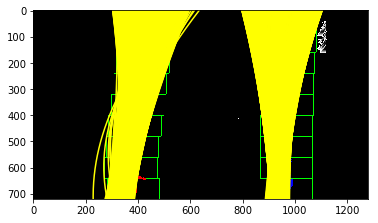

In [24]:
clip = VideoFileClip("project_video_result_warped.mp4")
lane_clip = clip.fl_image(histogram_test)
lane_clip.write_videofile("project_video_result_detect_lane_lines1.mp4", audio = False)

### video

In [29]:
%%HTML
<video width="640" height="360" controls>
  <source src="project_video_result_detect_lane_lines1.mp4" type="video/mp4">
</video>

#### histogram skip window selection

In [36]:
#left_fit_last = None
#right_fit_last = None

def histogram_skip_win_test(binary_warped):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    left_fit = left_fit_last
    right_fit = right_fit_last
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

    global left_fit_last
    left_fit_last = left_fit
    global right_fit_last
    right_fit_last = right_fit
    global ploty_last
    ploty_last = ploty
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    return result

#### visualization

(720, 1280, 3)


NameError: name 'left_fit_last' is not defined

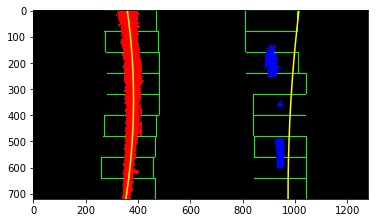

In [38]:
image = images[0]
out_img = histogram_test(image)

@interact
def detect_lane_lines_skip_win_test(i:(1,len(images)-1) = 1, images = fixed(images)):
    image = images[i] 
    print(image.shape)
        
    result = histogram_skip_win_test(image)

    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

#### video

In [39]:
clip = VideoFileClip("project_video_result_warped.mp4")
image = clip.get_frame(0)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
out_img, left_fit_last, right_fit_last, ploty_last = histogram_test(image)

clip1 = clip.set_start(t=1)
lane_clip = clip1.fl_image(histogram_skip_win)
#clip1.ipython_display(fps=20, loop=True, autoplay=True)
lane_clip.write_videofile("project_video_result_detect_lane_lines2.mp4", audio = False)


[MoviePy] >>>> Building video project_video_result_detect_lane_lines2.mp4
[MoviePy] Writing video project_video_result_detect_lane_lines2.mp4


100%|█████████▉| 1260/1261 [01:05<00:00, 19.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result_detect_lane_lines2.mp4 



In [40]:
%%HTML
<video width="640" height="360" controls>
  <source src="project_video_result_detect_lane_lines2.mp4" type="video/mp4">
</video>

## Determine the lane curvature

1891.33762316 1855.61123413


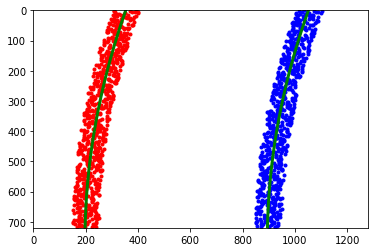

In [41]:
import numpy as np
import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize the images

# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

## Pipeline